<a href="https://colab.research.google.com/github/KristynaPijackova/Tutorials_NNs_and_signals/blob/main/DL23_natural_scenes_classification_resnet50_others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Scenes Classification: ResNet50, EfficientNetV2, MobileNetV2, VGG16

🖊

This jupyter notebook serves as example for the Deep Layers workshop. It was created by lorrespz (https://github.com/lorrespz) and edited to highlight some potentional issues that can occur when working with pre-trained models.

Source code: https://github.com/lorrespz/Image_classification_collection/blob/d84352a976e03a4213022950b7200e2f1acbfa24/natural-scenes-classification-resnet50-others.ipynb


Author: https://github.com/lorrespz, https://www.kaggle.com/lorresprz


Edited by: Kristyna Pijackova (edited parts will be highlighted with 🖊)

🖊

Dataset:
- 25k images
- 150x150x3 image size
- 6 categories
    - buildings
    - forest
    - glacier
    - mountain
    - sea
    - street

Source of Data: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data


In [ ]:
#🖊 Let's download the data from a folder stored in Google Drive

!gdown 1Tq-pM2SnMx5gUA3qTb1YFu6s5rAl7qjO
!unzip intel_image_classification.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
from glob import glob
import cv2
import tensorflow as tf

A list of available pretrained models (for image processing applications) can be found here:

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

# Loading images

Some information about the dataset is included here for clarity:

This dataset contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [ ]:
#🖊
train_path = '/content/seg_train/seg_train/'
test_path = '/content/seg_test/seg_test/'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#🖊
train_datagen = ImageDataGenerator(
                                  # rescale=1./255,  # Let's remove the rescaling
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
    )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
#🖊
test_datagen = ImageDataGenerator(#rescale=1./255. # Let's remove the rescaling
                                  )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)

Found 3000 images belonging to 6 classes.


#🖊

Why did we remove the scaling? Further down in this notebook we'll see that the author is using transfer learning with different CV models. Those models were pre-trained on the [Imagenet dataset](https://www.image-net.org/).

While the data is the same, the **preprocessing** that was done on it to initially train it **differs** for each one of them. And you can find out more in the descriptions on the [official page](https://keras.io/api/applications/) after you explore the specific model chosen by you.

Thus, we want to keep the data "neutral" and add the needed pre-processing as a layer in the model (as this is something Keras allows us to do).

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [ ]:
values = list(labels.values())

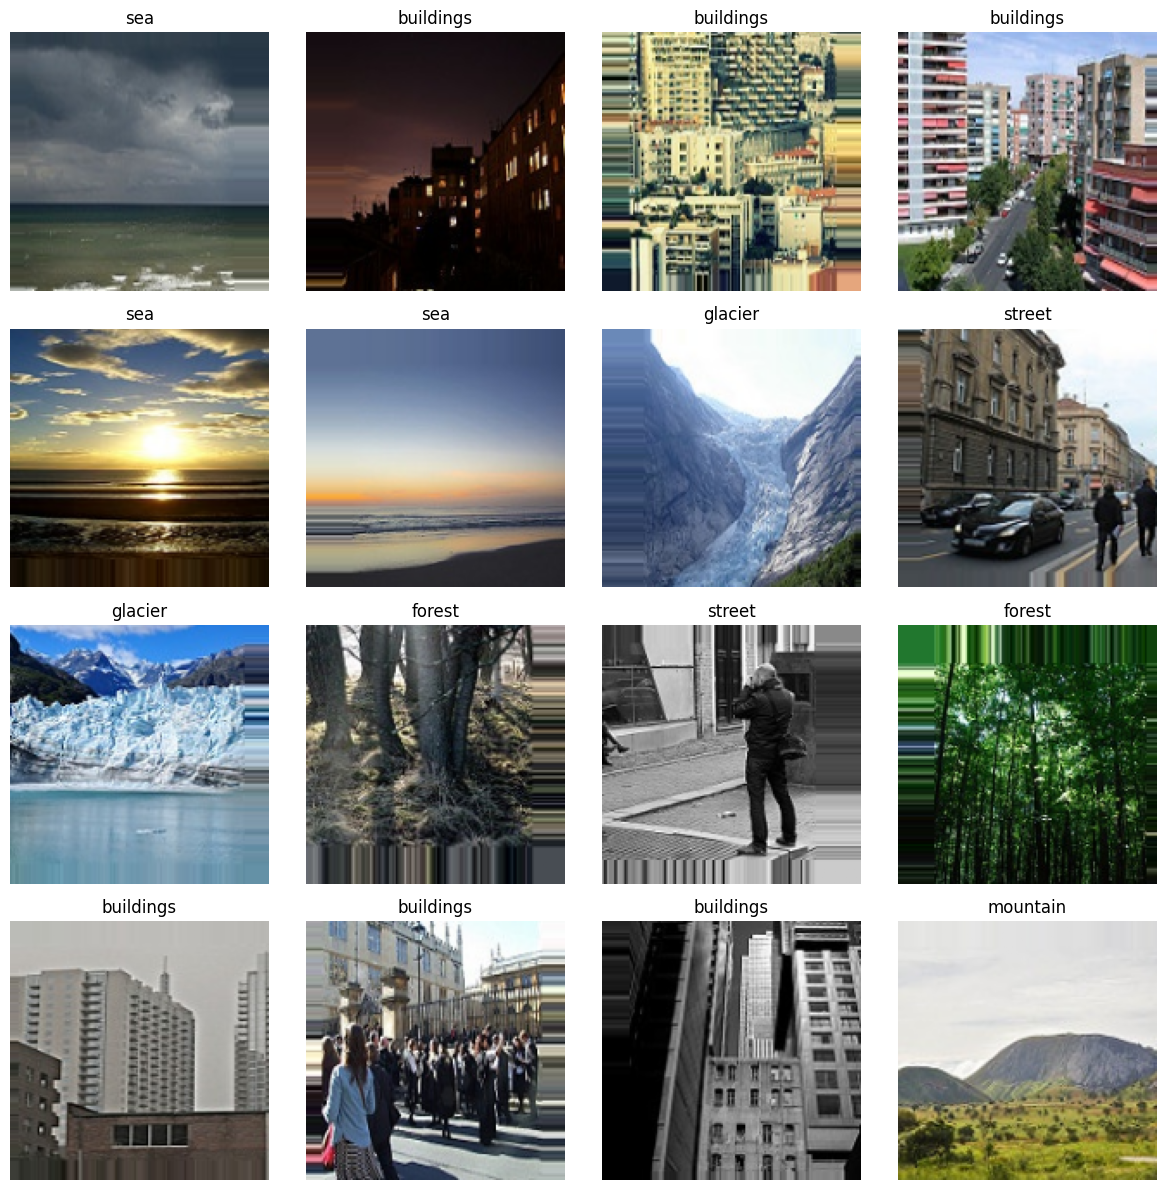

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow((train_generator[0][0][idx][:, :, :])/255.)
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In the following sections, 4 pretrained models were used to classify the images from this dataset. The models are: ResNet50, EfficientNetV2, MobileNetV2, VGG16. The customized top is the same for all 4 models and consists of a GlobalAveragePooling layer, followed by a Dense(128) layer, a Dropout layer (0.2) and a final Dense layer for classification. By using the same customized top, we can compare the performance of the 4 pretrained models later.

# ResNet50: Pretrained model + customized top

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False

In [ ]:
inputs = Input(shape=(150, 150, 3))
# 🖊
x = tf.keras.applications.resnet50.preprocess_input(inputs)

x = base_resnet50(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                           

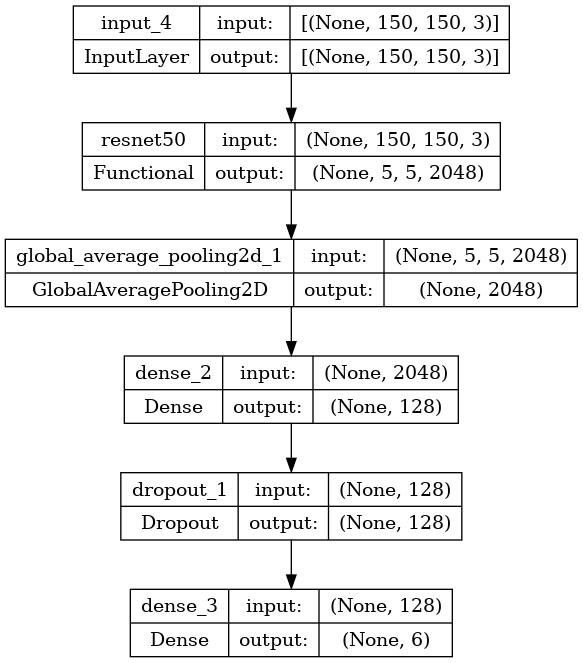

In [ ]:
plot_model(model_resnet50, show_shapes = True)

In [ ]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_rn50 = model_resnet50.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 177s 2s/step - loss: 1.7211 - accuracy: 0.2648 - val_loss: 1.6180 - val_accuracy: 0.3352
Epoch 2/15
88/88 [==============================] - 95s 1s/step - loss: 1.5386 - accuracy: 0.3752 - val_loss: 1.4562 - val_accuracy: 0.4169
Epoch 3/15
88/88 [==============================] - 98s 1s/step - loss: 1.4244 - accuracy: 0.4142 - val_loss: 1.3828 - val_accuracy: 0.4422
Epoch 4/15
88/88 [==============================] - 96s 1s/step - loss: 1.3467 - accuracy: 0.4544 - val_loss: 1.3134 - val_accuracy: 0.4932
Epoch 5/15
88/88 [==============================] - 95s 1s/step - loss: 1.2968 - accuracy: 0.4715 - val_loss: 1.2827 - val_accuracy: 0.4554
Epoch 6/15
88/88 [==============================] - 95s 1s/step - loss: 1.2425 - accuracy: 0.4956 - val_loss: 1.2301 - val_accuracy: 0.4996
Epoch 7/15
88/88 [==============================] - 95s 1s/step - loss: 1.2241 - accuracy: 0.5072 - val_loss: 1.1880 - val_accuracy: 0.5232
Epoch 8/15
88/88 [=

In [ ]:
acc_rn50 = history_rn50.history['accuracy']
val_acc_rn50 = history_rn50.history['val_accuracy']
loss_rn50 = history_rn50.history['loss']
val_loss_rn50 = history_rn50.history['val_loss']

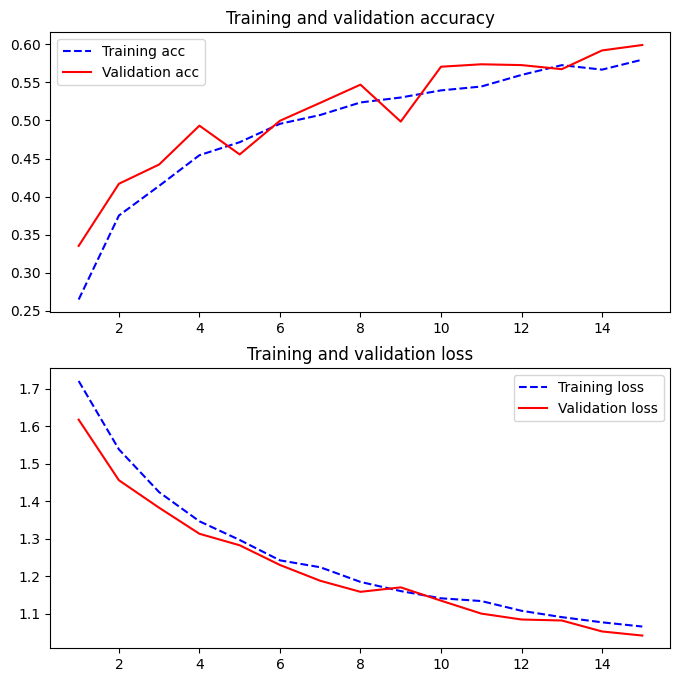

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_resnet50 = model_resnet50.predict(test_generator)
y_test = test_generator.classes
y_pred_resnet50 = np.argmax(pred_resnet50, axis=1)

24/24 [==============================] - 24s 1s/step


In [ ]:
rn_acc = accuracy_score(y_test,y_pred_resnet50)

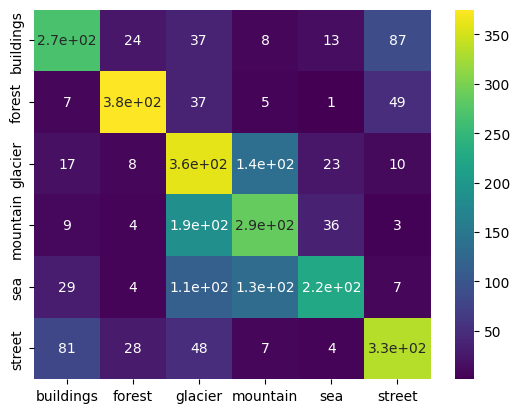

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_resnet50),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
plt.show()

# 🖊 ResNet50: Pretrained model + customized top

## Corrected preprocessing of the input data

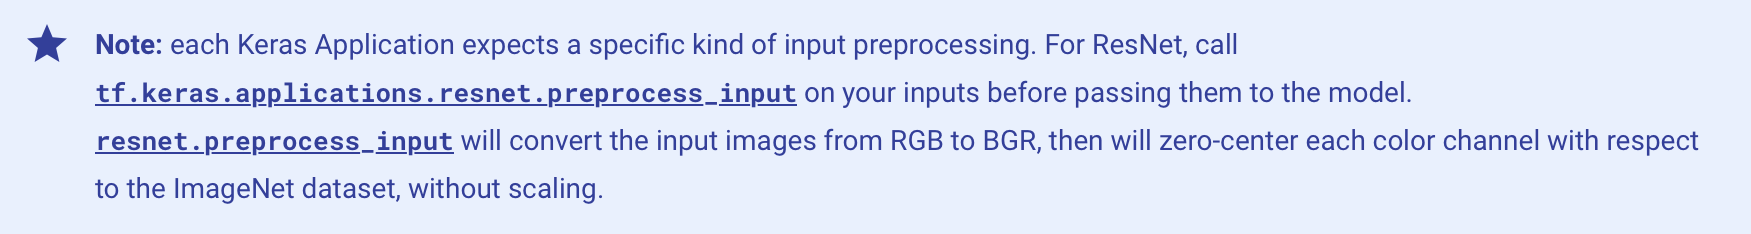

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
# 🖊 We add the resnet50.preprocess_input function that Keras recommends
# This function changes the RGB format to  BGR
# Then will zero-center each color channel with respect to the ImageNet dataset, without scaling
x = tf.keras.applications.resnet50.preprocess_input(inputs)

x = base_resnet50(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 150, 150, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 150, 150, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

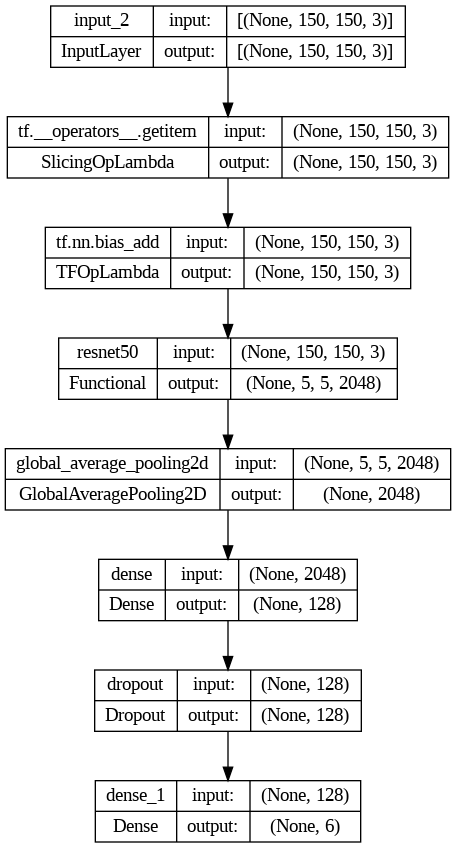

In [ ]:
plot_model(model_resnet50, show_shapes = True)

In [ ]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_rn50 = model_resnet50.fit(train_generator, validation_data = val_generator, epochs=5,callbacks=callbacks)

Epoch 1/5
88/88 [==============================] - 117s 1s/step - loss: 0.4022 - accuracy: 0.8535 - val_loss: 0.2732 - val_accuracy: 0.8994
Epoch 2/5
88/88 [==============================] - 98s 1s/step - loss: 0.2541 - accuracy: 0.9092 - val_loss: 0.2334 - val_accuracy: 0.9130
Epoch 3/5
88/88 [==============================] - 96s 1s/step - loss: 0.2401 - accuracy: 0.9101 - val_loss: 0.2514 - val_accuracy: 0.9091
Epoch 4/5
88/88 [==============================] - 93s 1s/step - loss: 0.2196 - accuracy: 0.9200 - val_loss: 0.2353 - val_accuracy: 0.9176
Epoch 5/5
88/88 [==============================] - 94s 1s/step - loss: 0.2061 - accuracy: 0.9249 - val_loss: 0.2348 - val_accuracy: 0.9183


In [ ]:
acc_rn50 = history_rn50.history['accuracy']
val_acc_rn50 = history_rn50.history['val_accuracy']
loss_rn50 = history_rn50.history['loss']
val_loss_rn50 = history_rn50.history['val_loss']

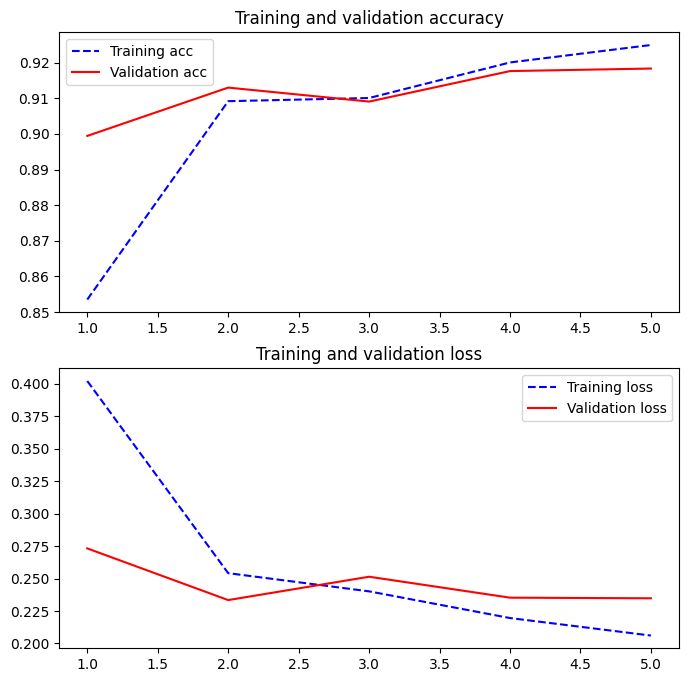

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_resnet50 = model_resnet50.predict(test_generator)
y_test = test_generator.classes
y_pred_resnet50 = np.argmax(pred_resnet50, axis=1)

24/24 [==============================] - 7s 261ms/step


In [ ]:
rn_acc = accuracy_score(y_test,y_pred_resnet50)

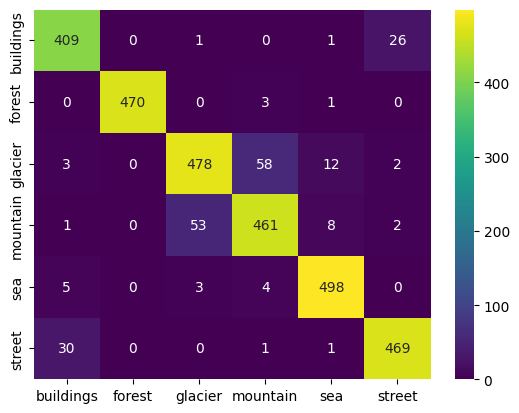

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_resnet50),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis', fmt='g')  # 🖊 add format='g' to show normal values, not scientific ones
plt.show()

# EfficientNetV2: Pretrained model + customized top

In [ ]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

35839040/35839040 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 5, 5, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               180352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774 

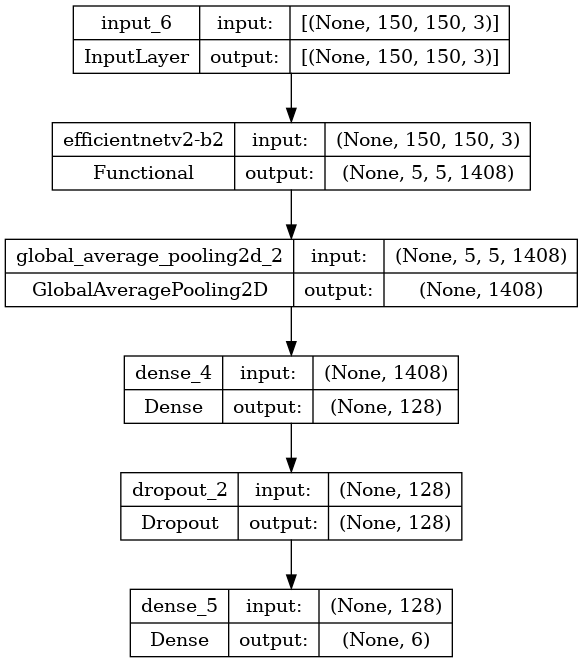

In [ ]:
plot_model(model_effnet, show_shapes = True)

In [ ]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 103s 1s/step - loss: 1.7913 - accuracy: 0.1957 - val_loss: 1.7711 - val_accuracy: 0.1815
Epoch 2/15
88/88 [==============================] - 90s 1s/step - loss: 1.7616 - accuracy: 0.2231 - val_loss: 1.7413 - val_accuracy: 0.2885
Epoch 3/15
88/88 [==============================] - 88s 1s/step - loss: 1.7218 - accuracy: 0.2467 - val_loss: 1.6937 - val_accuracy: 0.2807
Epoch 4/15
88/88 [==============================] - 99s 1s/step - loss: 1.6766 - accuracy: 0.2705 - val_loss: 1.6687 - val_accuracy: 0.3014
Epoch 5/15
88/88 [==============================] - 97s 1s/step - loss: 1.6491 - accuracy: 0.2781 - val_loss: 1.6177 - val_accuracy: 0.3078
Epoch 6/15
88/88 [==============================] - 93s 1s/step - loss: 1.6111 - accuracy: 0.2931 - val_loss: 1.6097 - val_accuracy: 0.3131
Epoch 7/15
88/88 [==============================] - 89s 1s/step - loss: 1.5925 - accuracy: 0.2962 - val_loss: 1.5888 - val_accuracy: 0.2903
Epoch 8/15
88/88 [=

In [ ]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

In [ ]:
pred_ef = model_effnet.predict(test_generator)
y_test = test_generator.classes
y_pred_ef = np.argmax(pred_ef, axis=1)

24/24 [==============================] - 8s 268ms/step


In [ ]:
effn_acc = accuracy_score(y_test,y_pred_ef)
effn_acc

0.3606666666666667

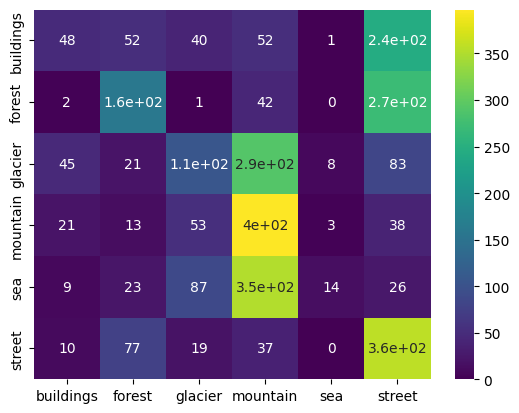

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_ef),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
plt.show()

# 🖊 EfficientNetV2: Pretrained model + customized top

## Corrected preprocessing of the input data

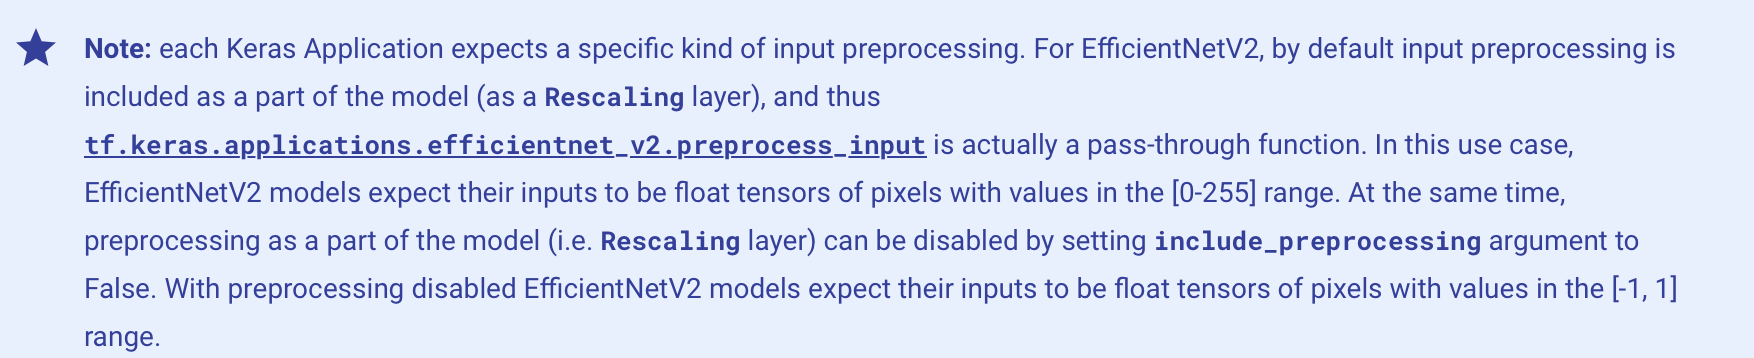

In [ ]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

In [ ]:
inputs = Input(shape=(150, 150, 3))
# 🖊 We add the resnet50.preprocess_input function that Keras recommends
# In this use case, EfficientNetV2 models expect their inputs to be float tensors
# of pixels with values in the [0-255] range.
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)

x = base_effnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774 

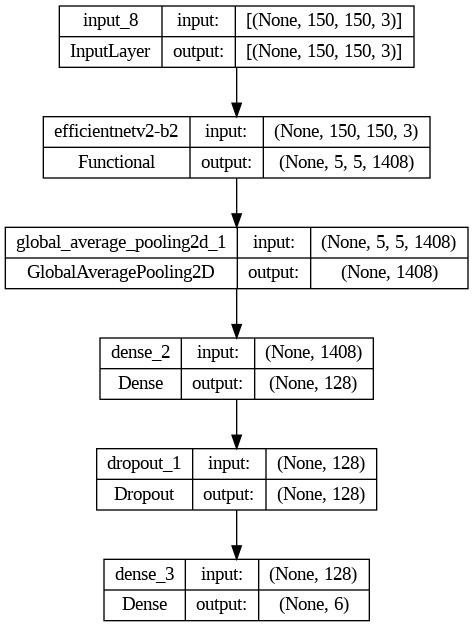

In [ ]:
plot_model(model_effnet, show_shapes = True)

In [ ]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(train_generator, validation_data = val_generator, epochs=5,callbacks=callbacks)

Epoch 1/5
88/88 [==============================] - 124s 1s/step - loss: 0.4108 - accuracy: 0.8529 - val_loss: 0.2666 - val_accuracy: 0.9023
Epoch 2/5
88/88 [==============================] - 95s 1s/step - loss: 0.2672 - accuracy: 0.9011 - val_loss: 0.2494 - val_accuracy: 0.9133
Epoch 3/5
88/88 [==============================] - 91s 1s/step - loss: 0.2421 - accuracy: 0.9122 - val_loss: 0.2327 - val_accuracy: 0.9130
Epoch 4/5
88/88 [==============================] - 92s 1s/step - loss: 0.2261 - accuracy: 0.9185 - val_loss: 0.2458 - val_accuracy: 0.9091
Epoch 5/5
88/88 [==============================] - 89s 1s/step - loss: 0.2128 - accuracy: 0.9222 - val_loss: 0.2377 - val_accuracy: 0.9151


In [ ]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

In [ ]:
pred_ef = model_effnet.predict(test_generator)
y_test = test_generator.classes
y_pred_ef = np.argmax(pred_ef, axis=1)

24/24 [==============================] - 8s 213ms/step


In [ ]:
effn_acc = accuracy_score(y_test,y_pred_ef)
effn_acc

0.9196666666666666

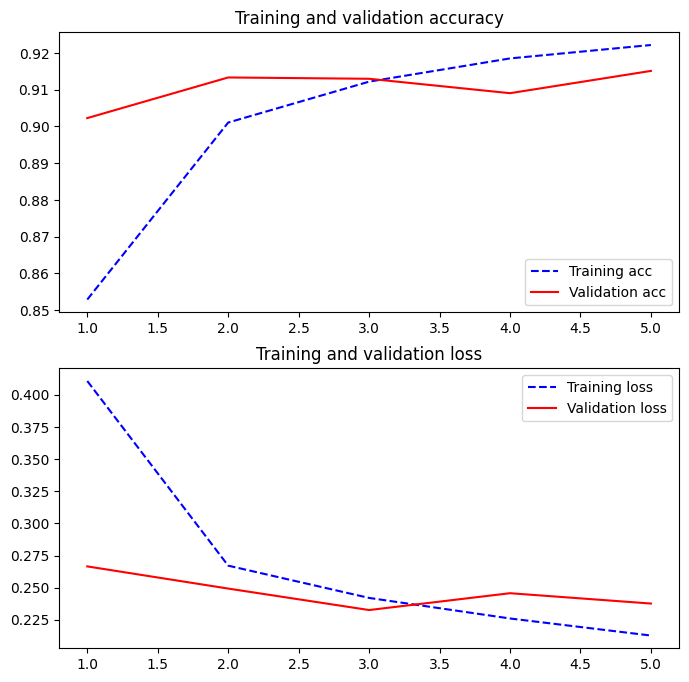

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_ef) + 1)
ax[0].plot(epochs, acc_ef, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_ef, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_ef, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_ef, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

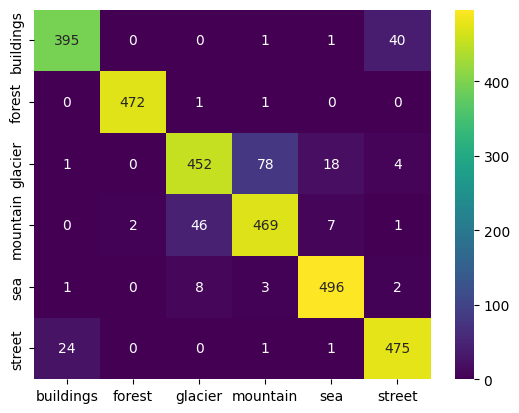

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_ef),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis', fmt='g')  # 🖊 add format='g' to show normal values, not scientific ones
plt.show()

# MobileNetV2: Pretrained model + customized top

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
base_mn = MobileNetV2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_mn.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
x = base_mn(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_mnet = Model(inputs, x)
model_mnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774 

In [ ]:
model_mnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_mn = model_mnet.fit(train_generator, validation_data = val_generator, epochs=15,callbacks=callbacks)

Epoch 1/15
88/88 [==============================] - 94s 1s/step - loss: 0.5341 - accuracy: 0.8025 - val_loss: 0.3498 - val_accuracy: 0.8727
Epoch 2/15
88/88 [==============================] - 87s 992ms/step - loss: 0.3609 - accuracy: 0.8654 - val_loss: 0.3530 - val_accuracy: 0.8691
Epoch 3/15
88/88 [==============================] - 87s 996ms/step - loss: 0.3286 - accuracy: 0.8742 - val_loss: 0.3596 - val_accuracy: 0.8602
Epoch 4/15
88/88 [==============================] - 87s 995ms/step - loss: 0.3124 - accuracy: 0.8846 - val_loss: 0.2993 - val_accuracy: 0.8869
Epoch 5/15
88/88 [==============================] - 90s 1s/step - loss: 0.2994 - accuracy: 0.8887 - val_loss: 0.2954 - val_accuracy: 0.8909
Epoch 6/15
88/88 [==============================] - 92s 1s/step - loss: 0.2863 - accuracy: 0.8926 - val_loss: 0.3101 - val_accuracy: 0.8937
Epoch 7/15
88/88 [==============================] - 88s 1s/step - loss: 0.2831 - accuracy: 0.8958 - val_loss: 0.3138 - val_accuracy: 0.8852
Epoch 8/15


In [ ]:
acc_mn = history_mn.history['accuracy']
val_acc_mn = history_mn.history['val_accuracy']
loss_mn = history_mn.history['loss']
val_loss_mn = history_mn.history['val_loss']

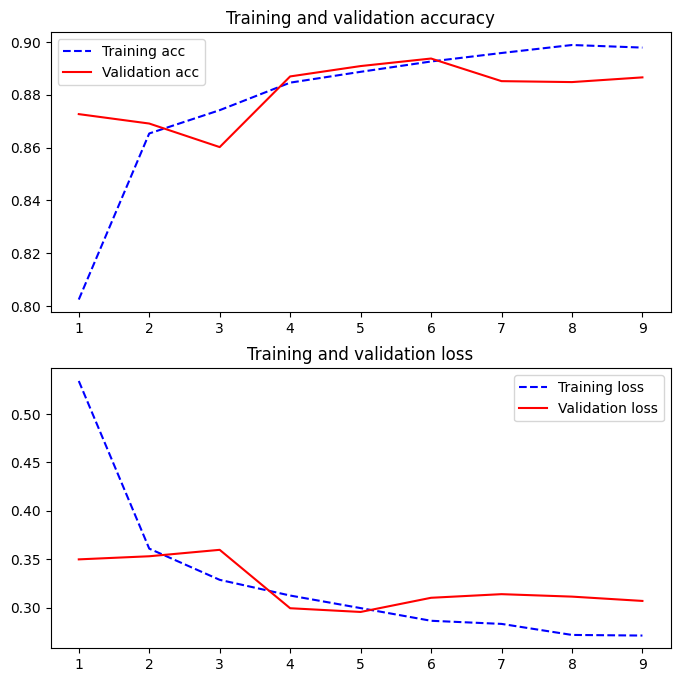

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_mn) + 1)
ax[0].plot(epochs, acc_mn, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_mn, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_mn, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_mn, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_mn = model_mnet.predict(test_generator)
y_test = test_generator.classes
y_pred_mn = np.argmax(pred_mn, axis=1)

24/24 [==============================] - 7s 256ms/step


In [ ]:
mn_acc = accuracy_score(y_test,y_pred_mn)
mn_acc

0.905

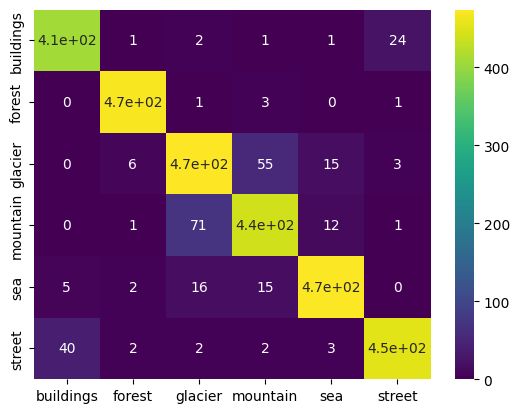

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_mn),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
plt.show()

# 🖊 MobileNetV2: Pretrained model + customized top

## Corrected preprocessing of the input data

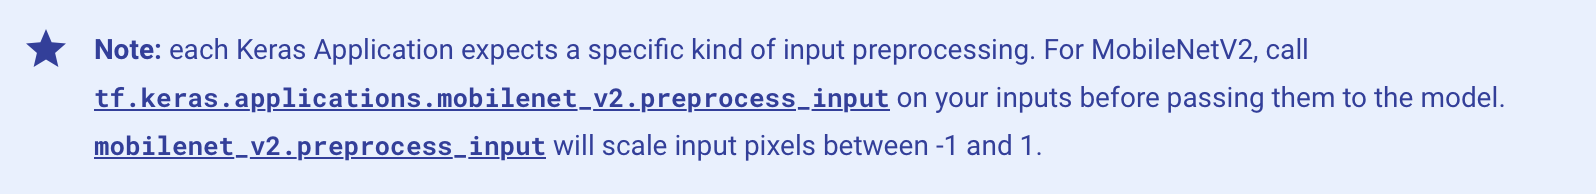


In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
base_mn = MobileNetV2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_mn.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_mn(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(6, activation='softmax')(x)

model_mnet = Model(inputs, x)
model_mnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 150, 150, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 150, 150, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [ ]:
model_mnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_mn = model_mnet.fit(train_generator, validation_data = val_generator, epochs=5,callbacks=callbacks)

Epoch 1/5
88/88 [==============================] - 94s 1s/step - loss: 0.4755 - accuracy: 0.8275 - val_loss: 0.3160 - val_accuracy: 0.8848
Epoch 2/5
88/88 [==============================] - 88s 1000ms/step - loss: 0.3360 - accuracy: 0.8784 - val_loss: 0.3037 - val_accuracy: 0.8869
Epoch 3/5
88/88 [==============================] - 94s 1s/step - loss: 0.3086 - accuracy: 0.8857 - val_loss: 0.2838 - val_accuracy: 0.8927
Epoch 4/5
88/88 [==============================] - 87s 990ms/step - loss: 0.2830 - accuracy: 0.8950 - val_loss: 0.2861 - val_accuracy: 0.8987
Epoch 5/5
88/88 [==============================] - 87s 994ms/step - loss: 0.2702 - accuracy: 0.9030 - val_loss: 0.3438 - val_accuracy: 0.8748


In [ ]:
acc_mn = history_mn.history['accuracy']
val_acc_mn = history_mn.history['val_accuracy']
loss_mn = history_mn.history['loss']
val_loss_mn = history_mn.history['val_loss']

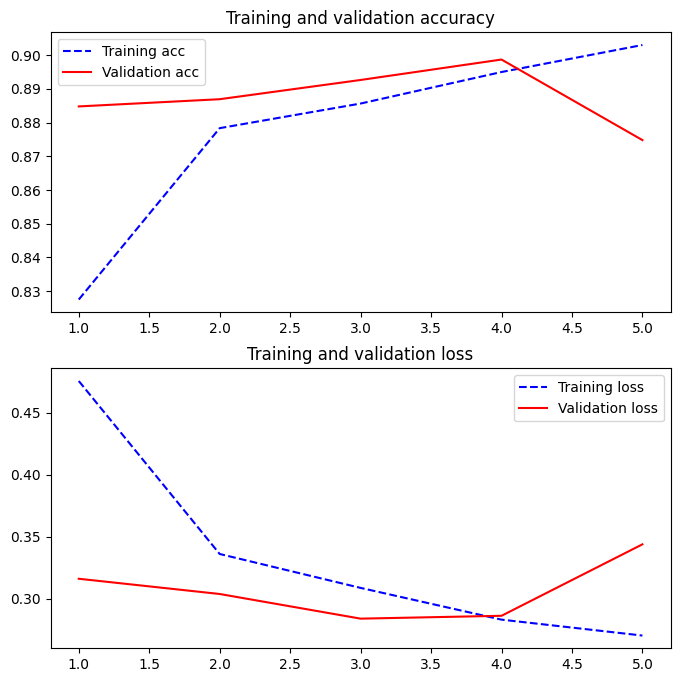

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_mn) + 1)
ax[0].plot(epochs, acc_mn, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_mn, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_mn, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_mn, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_mn = model_mnet.predict(test_generator)
y_test = test_generator.classes
y_pred_mn = np.argmax(pred_mn, axis=1)

24/24 [==============================] - 6s 235ms/step


In [ ]:
mn_acc = accuracy_score(y_test,y_pred_mn)
mn_acc

0.8916666666666667

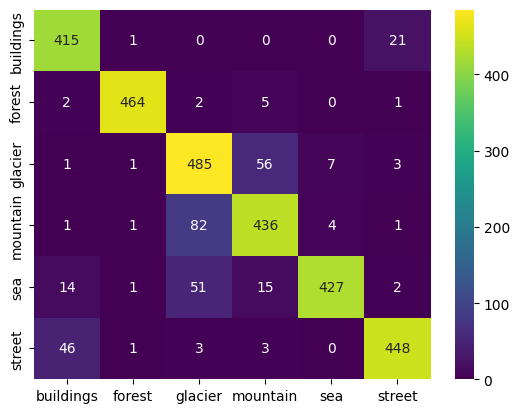

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_mn),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis', fmt='g')  # 🖊 add format='g' to show normal values, not scientific ones
plt.show()

# VGG16 model: Pretrained model + customized top

In [ ]:
base_VGG16 = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_VGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
x = base_VGG16(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model_vgg16 = Model(inputs, x)
model_vgg16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                           

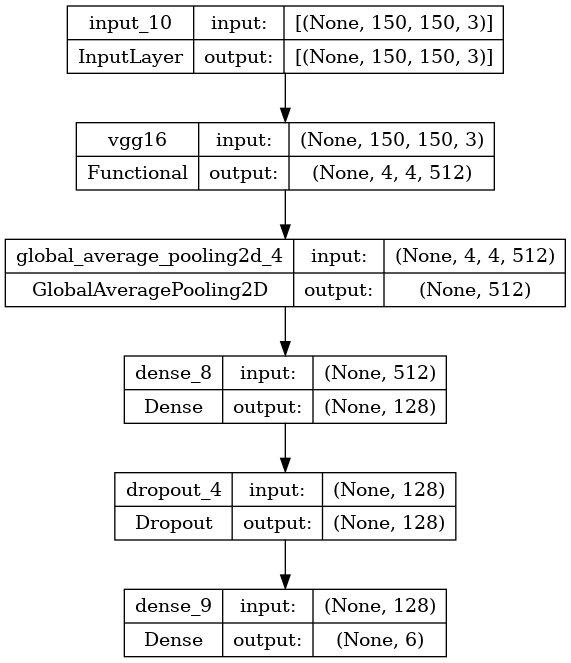

In [ ]:
plot_model(model_vgg16, show_shapes=True)

In [ ]:
model_vgg16.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model_vgg16.fit(train_generator, validation_data = val_generator, epochs=12,
                callbacks=callbacks)

Epoch 1/12
88/88 [==============================] - 117s 1s/step - loss: 0.9872 - accuracy: 0.6386 - val_loss: 0.6364 - val_accuracy: 0.7782
Epoch 2/12
88/88 [==============================] - 97s 1s/step - loss: 0.6014 - accuracy: 0.7848 - val_loss: 0.5442 - val_accuracy: 0.7924
Epoch 3/12
88/88 [==============================] - 96s 1s/step - loss: 0.5352 - accuracy: 0.8045 - val_loss: 0.4880 - val_accuracy: 0.8224
Epoch 4/12
88/88 [==============================] - 97s 1s/step - loss: 0.4984 - accuracy: 0.8215 - val_loss: 0.4725 - val_accuracy: 0.8267
Epoch 5/12
88/88 [==============================] - 99s 1s/step - loss: 0.4770 - accuracy: 0.8221 - val_loss: 0.4535 - val_accuracy: 0.8345
Epoch 6/12
88/88 [==============================] - 95s 1s/step - loss: 0.4656 - accuracy: 0.8314 - val_loss: 0.4456 - val_accuracy: 0.8295
Epoch 7/12
88/88 [==============================] - 98s 1s/step - loss: 0.4498 - accuracy: 0.8377 - val_loss: 0.4336 - val_accuracy: 0.8352
Epoch 8/12
88/88 [=

In [ ]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']

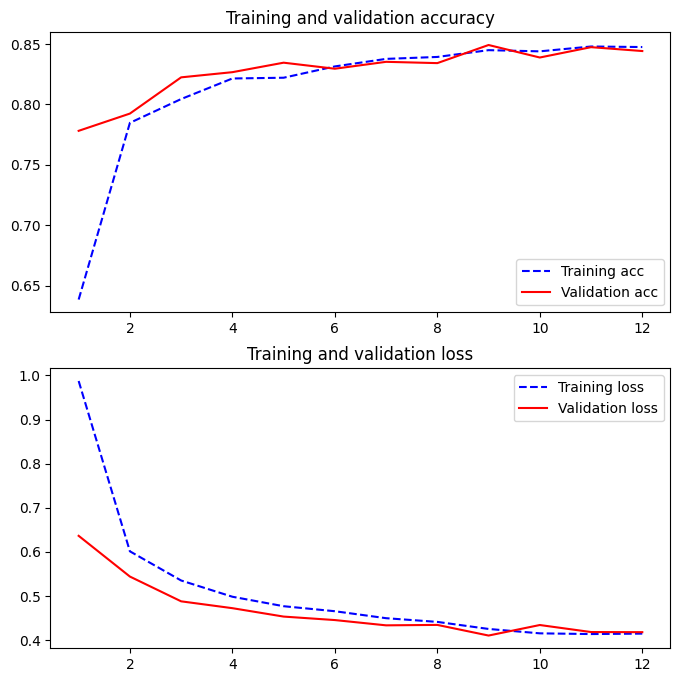

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_vgg) + 1)
ax[0].plot(epochs, acc_vgg, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_vgg, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_vgg, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_vgg, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_vgg16 = model_vgg16.predict(test_generator)
y_test = test_generator.classes
y_pred_vgg16 = np.argmax(pred_vgg16, axis=1)

24/24 [==============================] - 12s 513ms/step


In [ ]:
vgg16_acc = accuracy_score(y_test,y_pred_vgg16)
vgg16_acc

0.8576666666666667

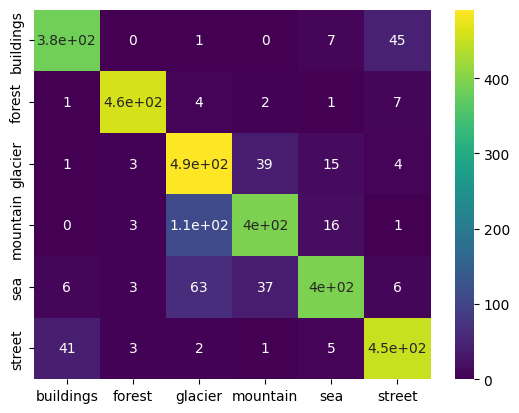

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_vgg16),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
plt.show()

# 🖊 VGG16 model: Pretrained model + customized top

## Corrected preprocessing of the input data

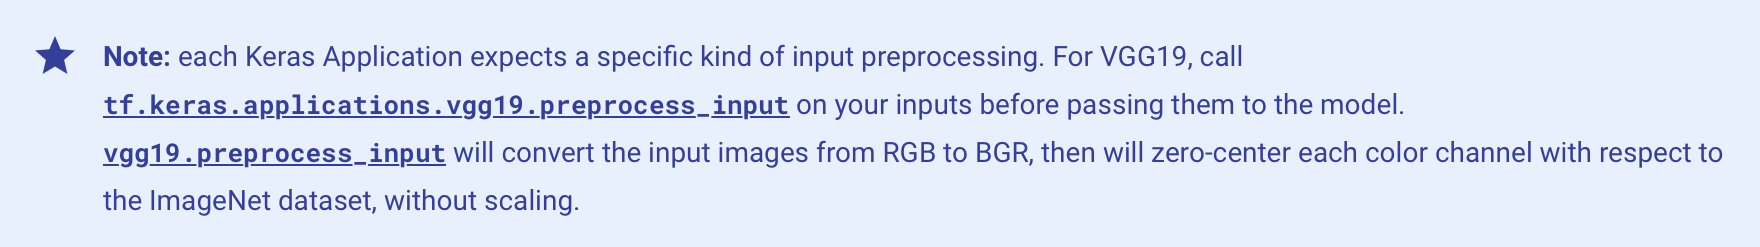

In [ ]:
base_VGG16 = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_VGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
inputs = Input(shape=(150, 150, 3))
# 🖊 Once again, as in ResNet50 the image format expects BRG not RGB images that are zero-centered
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = base_VGG16(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

model_vgg16 = Model(inputs, x)
model_vgg16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

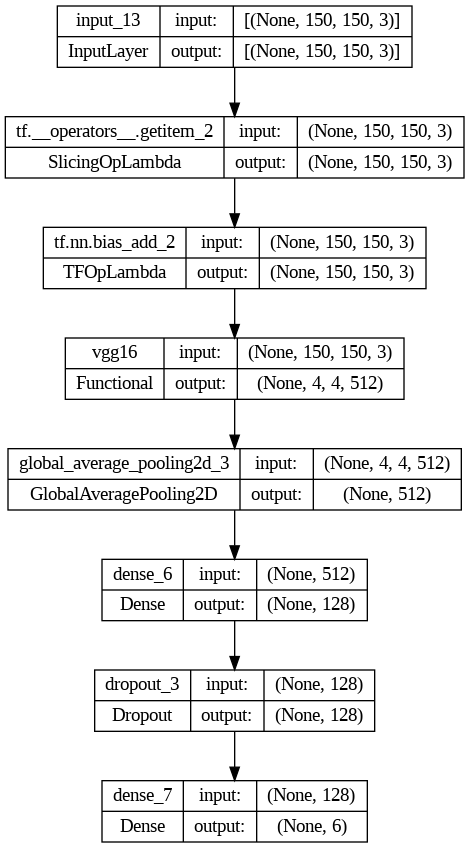

In [ ]:
plot_model(model_vgg16, show_shapes=True)

In [ ]:
model_vgg16.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model_vgg16.fit(train_generator, validation_data = val_generator, epochs=5,
                callbacks=callbacks)

Epoch 1/5
88/88 [==============================] - 119s 1s/step - loss: 1.0003 - accuracy: 0.7665 - val_loss: 0.4387 - val_accuracy: 0.8631
Epoch 2/5
88/88 [==============================] - 95s 1s/step - loss: 0.4482 - accuracy: 0.8508 - val_loss: 0.3606 - val_accuracy: 0.8734
Epoch 3/5
88/88 [==============================] - 95s 1s/step - loss: 0.3467 - accuracy: 0.8777 - val_loss: 0.3121 - val_accuracy: 0.8944
Epoch 4/5
88/88 [==============================] - 95s 1s/step - loss: 0.3156 - accuracy: 0.8852 - val_loss: 0.3127 - val_accuracy: 0.8909
Epoch 5/5
88/88 [==============================] - 96s 1s/step - loss: 0.2949 - accuracy: 0.8912 - val_loss: 0.3092 - val_accuracy: 0.8930


In [ ]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']

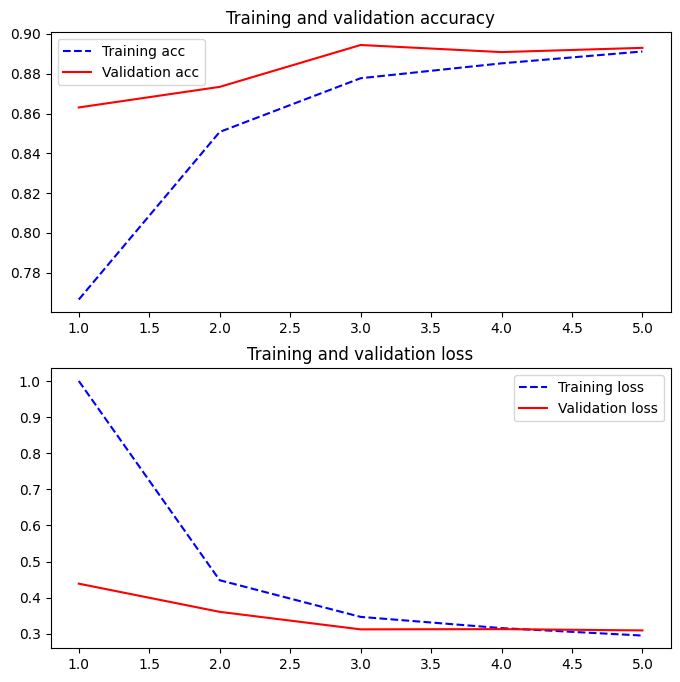

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_vgg) + 1)
ax[0].plot(epochs, acc_vgg, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_vgg, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_vgg, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_vgg, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
pred_vgg16 = model_vgg16.predict(test_generator)
y_test = test_generator.classes
y_pred_vgg16 = np.argmax(pred_vgg16, axis=1)

24/24 [==============================] - 11s 449ms/step


In [ ]:
vgg16_acc = accuracy_score(y_test,y_pred_vgg16)
vgg16_acc

0.8983333333333333

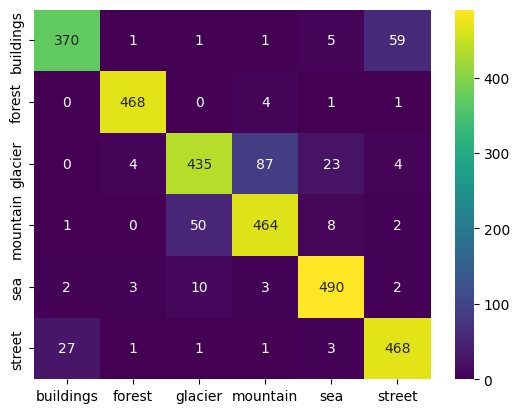

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_vgg16),
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis', fmt='g')  # 🖊 add format='g' to show normal values, not scientific ones
plt.show()

# Comparison of accuracy

In [ ]:
d  = pd.DataFrame({'Model': ['EfficientNetV2', 'ResNet50','VGG16', 'MobileNetV2'],
      'Accuracy': [effn_acc, rn_acc,  vgg16_acc,  mn_acc]})
d = d.set_index('Model')

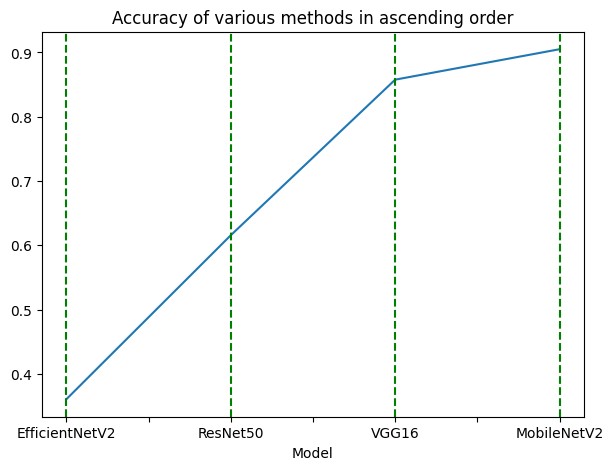

In [ ]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in ascending order');

# 🖊 Comparison of accuracy of corrected models

In [ ]:
d  = pd.DataFrame({'Model': ['EfficientNetV2', 'ResNet50','VGG16', 'MobileNetV2'],
      'Accuracy': [effn_acc, rn_acc,  vgg16_acc,  mn_acc]})
d = d.set_index('Model')

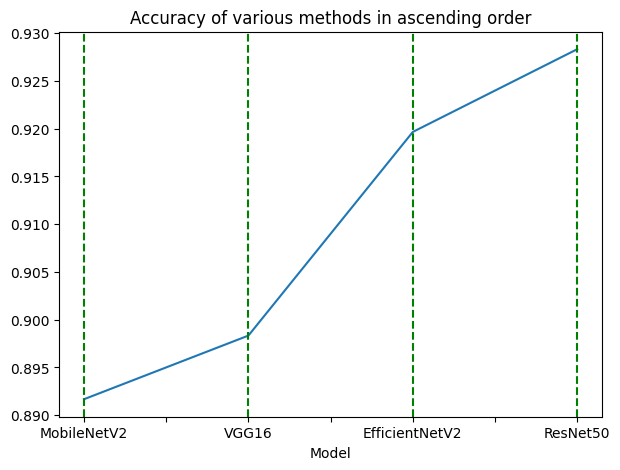

In [58]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in ascending order');

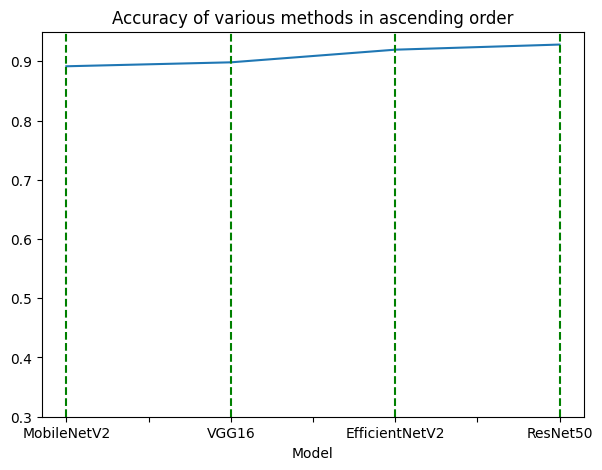

In [57]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.ylim([0.3, 0.95])
plt.title('Accuracy of various methods in ascending order');